# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set(style="ticks", context="paper")

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer

In [4]:
from bernstein_paper.util.visualization import plot_patches

# Function Definition

In [5]:
import os

import tensorflow as tf

from functools import partial

from bernstein_paper.data.dataset import WindowedTimeSeriesDataSet
from bernstein_paper.data.splitter import TimeSeriesSplit

In [6]:
def load_data(data_path: str,
              history_size,
              prediction_size,
              history_columns=['load', 'is_holiday', 'tempC'],
              meta_columns=['is_holiday', 'tempC'],
              prediction_columns=['load'],
              splits=['train', 'validate', 'test'],
              shift=None,
              validation_split=None,
              batch_size=32,
              cycle_length=10,
              shuffle_buffer_size=1000,
              seed=42):
    """
    Loads the preprocessed CER data and build the dataset.

    :param      data_path:            The path to the folder containing the
                                      train.csv and test.csv
    :type       data_path:            str
    :param      history_size:         The number of time steps of the historic
                                      data a patch should contain
    :type       history_size:         int
    :param      prediction_size:      The number of time steps in the
                                      prediction horizon a step should contain
    :type       prediction_size:      int
    :param      history_columns:     The historic columns
    :type       history_columns:     Array
    :param      meta_columns:         The column names to be used as horizon
                                      data.
    :type       meta_columns:         Array
    :param      prediction_columns:   The columns to predict
    :type       prediction_columns:   Array
    :param      splits:               The data splits to be generated. At least
                                      one of 'train', 'validate' or 'test'
    :type       splits:               Array
    :param      shift:                The amount of time steps by which the
                                      window moves on each iteration
    :type       shift:                int
    :param      validation_split:     The amount of data reserved from the
                                      training set for validation
    :type       validation_split:     float
    :param      batch_size:           The batch size
    :type       batch_size:           int
    :param      cycle_length:         The number of input elements that are
                                      processed concurrently
    :type       cycle_length:         int
    :param      shuffle_buffer_size:  The shuffle buffer size
    :type       shuffle_buffer_size:  int
    :param      seed:                 The seed used by the pseudo random
                                      generators
    :type       seed:                 int

    :returns:   A dict containing the windowed TensorFlow datasets generated
                from csv file in `data_path` for the given `spits`.
    :rtype:     dict
    """

    # common ##################################################################
    data = {}

    column_transformers = {}
    column_transformers['load'] = lambda x: tf.math.log(x + 1e-5)
    column_transformers['weekday'] = lambda x: tf.one_hot(tf.cast(tf.squeeze(x), tf.uint8), 6)

    make_dataset = partial(WindowedTimeSeriesDataSet,
                           history_size=history_size,
                           prediction_size=prediction_size,
                           history_columns=history_columns,
                           meta_columns=meta_columns,
                           prediction_columns=prediction_columns,
                           shift=shift,
                           batch_size=32,
                           cycle_length=cycle_length,
                           shuffle_buffer_size=shuffle_buffer_size,
                           seed=seed,
                           column_transformers=column_transformers)

    # train data ##############################################################
    train_data_path = os.path.join(data_path, 'train.csv')
    test_data_path = os.path.join(data_path, 'test.csv')

    if 'train' in splits:
        if validation_split is not None:
            data_splitter = TimeSeriesSplit(
                1 - validation_split, TimeSeriesSplit.LEFT)
        else:
            data_splitter = None

        data['train'] = make_dataset(
            file_path=train_data_path,
            data_splitter=data_splitter)()

    # validation data #########################################################
    if 'validate' in splits and validation_split is not None:
        data_splitter = TimeSeriesSplit(
            validation_split, TimeSeriesSplit.RIGHT)

        data['validate'] = make_dataset(
            file_path=train_data_path,
            data_splitter=data_splitter)()

    # test data ###############################################################
    if 'test' in splits:
        data['test'] = make_dataset(
            file_path=test_data_path)()

    return data


# Load Dataset

In [7]:
data_path="../../data/CER Electricity Revised March 2012/preprocessed/mini/"

In [8]:
test_csv=pd.read_csv(
    os.path.join(data_path,'test.csv'),
    parse_dates=['date_time'],
    infer_datetime_format=True,
    index_col=['date_time'],
    dtype={'id': 'uint16',
           'load': 'float32',
           'is_holiday': 'uint8',
           'weekday': 'uint8'})

In [9]:
#ref.: https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
def encode(data, cycl_name, cycl = None):
    if cycl is None:
        cycl = getattr(data.index, cycl_name)
    cycl_max = cycl.max()
    data[cycl_name + '_sin'] = np.float32(np.sin(2 * np.pi * cycl/cycl_max))
    data[cycl_name + '_cos'] = np.float32(np.cos(2 * np.pi * cycl/cycl_max))
    return data

In [10]:
test_csv = encode(test_csv, 'dayofyear')
test_csv = encode(test_csv, 'weekday')
test_csv = encode(test_csv, 'time', test_csv.index.hour*60+test_csv.index.minute)

In [11]:
test_csv.dtypes,test_csv.shape

(id                uint16
 load             float32
 is_holiday         uint8
 weekday            uint8
 dayofyear_sin    float32
 dayofyear_cos    float32
 weekday_sin      float32
 weekday_cos      float32
 time_sin         float32
 time_cos         float32
 dtype: object,
 (1062864, 10))

In [12]:
test_csv.head()

,id,load,is_holiday,weekday,dayofyear_sin,dayofyear_cos,weekday_sin,weekday_cos,time_sin,time_cos
date_time,,,,,,,,,,
2010-11-01 00:00:00,1035,19.171,0,0,-0.858764,0.512371,0.0,1.0,0.000000,1.000000
2010-11-01 00:30:00,1035,15.843,0,0,-0.858764,0.512371,0.0,1.0,0.133287,0.991077
2010-11-01 01:00:00,1035,6.561,0,0,-0.858764,0.512371,0.0,1.0,0.264195,0.964469
2010-11-01 01:30:00,1035,5.640,0,0,-0.858764,0.512371,0.0,1.0,0.390389,0.920650
2010-11-01 02:00:00,1035,6.238,0,0,-0.858764,0.512371,0.0,1.0,0.509617,0.860402


In [13]:
test_csv.columns

Index(['id', 'load', 'is_holiday', 'weekday', 'dayofyear_sin', 'dayofyear_cos',
       'weekday_sin', 'weekday_cos', 'time_sin', 'time_cos'],
      dtype='object')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


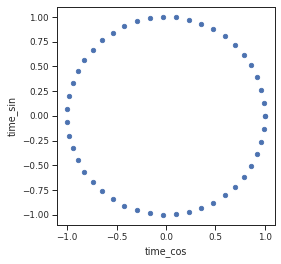

In [14]:
test_csv.head(48).plot.scatter('time_cos', 'time_sin').set_aspect('equal')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


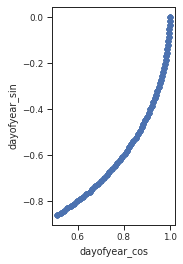

In [15]:
test_csv[test_csv.id==1035].head(48*365//2).plot.scatter('dayofyear_cos', 'dayofyear_sin').set_aspect('equal')

In [16]:
test_csv.index.hour*60+test_csv.index.minute

Int64Index([   0,   30,   60,   90,  120,  150,  180,  210,  240,  270,
            ...
            1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410],
           dtype='int64', name='date_time', length=1062864)

In [17]:
test_csv.dtypes

id                uint16
load             float32
is_holiday         uint8
weekday            uint8
dayofyear_sin    float32
dayofyear_cos    float32
weekday_sin      float32
weekday_cos      float32
time_sin         float32
time_cos         float32
dtype: object

In [18]:
load_data_kwds=dict(
    data_path =  data_path,
    history_size =  48*7*2,
    prediction_size =  48*1,
    shift = 48*1,
    history_columns =  ['load'],
    meta_columns = ['dayofyear_sin', 'dayofyear_cos', 'weekday', 'time_sin', 'time_cos', 'is_holiday'],
    prediction_columns =  ['load'],
    validation_split =  0.1,
    batch_size =  32,
    cycle_length =  10,
    shuffle_buffer_size =  100,
    seed =  1
)

In [19]:
data_sets=load_data(**load_data_kwds)
data_sets

{'train': <CacheDataset shapes: (((None, 672, 1), (None, 1, None)), (None, 48, 1)), types: ((tf.float32, tf.float32), tf.float32)>,
 'validate': <CacheDataset shapes: (((None, 672, 1), (None, 1, None)), (None, 48, 1)), types: ((tf.float32, tf.float32), tf.float32)>,
 'test': <CacheDataset shapes: (((None, 672, 1), (None, 1, None)), (None, 48, 1)), types: ((tf.float32, tf.float32), tf.float32)>}

In [20]:
train_data = data_sets['train']

In [21]:
(x1,x2),y = next(train_data.as_numpy_iterator())
x1.shape, x2.shape, y.shape

((32, 672, 1), (32, 1, 11), (32, 48, 1))

In [22]:
x1[0]

array([[-1.61943769e+00],
       [-1.72591555e+00],
       [-2.47681952e+00],
       [-3.10087061e+00],
       [-2.36435413e+00],
       [-3.19393921e+00],
       [-2.43030477e+00],
       [-3.16984773e+00],
       [-2.44173217e+00],
       [-2.86452866e+00],
       [-2.28268456e+00],
       [-3.16984773e+00],
       [-2.43030477e+00],
       [-3.19393921e+00],
       [-2.44173217e+00],
       [-3.24393725e+00],
       [-3.10087061e+00],
       [-3.38259816e-01],
       [-2.38585806e+00],
       [-1.36253870e+00],
       [ 1.44974440e-01],
       [-2.15659112e-01],
       [-2.15659112e-01],
       [-2.14419231e-01],
       [-1.78970158e+00],
       [-2.24422193e+00],
       [ 1.18680470e-01],
       [ 2.74604410e-01],
       [ 2.72322178e-01],
       [-5.81587851e-01],
       [-2.08739305e+00],
       [-3.01573086e+00],
       [-4.96041775e+00],
       [-3.03634596e+00],
       [-3.86275673e+00],
       [-3.44170690e+00],
       [-3.29656720e+00],
       [-2.79671741e+00],
       [-2.0

In [23]:
x2[0]

array([[-0.5049611 ,  0.86314213,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]], dtype=float32)

In [24]:
y[0]

array([[-1.6347045e+00],
       [-1.9518578e+00],
       [-3.1698477e+00],
       [-2.5381808e+00],
       [-3.1939392e+00],
       [-2.4649863e+00],
       [-3.1939392e+00],
       [-2.5381808e+00],
       [-3.1463227e+00],
       [-2.5509183e+00],
       [-2.9563193e+00],
       [-2.6735039e+00],
       [-2.8132441e+00],
       [-2.7644618e+00],
       [-2.7332141e+00],
       [-2.5638201e+00],
       [-2.5638201e+00],
       [-2.5509183e+00],
       [-2.3967860e+00],
       [-2.6035550e+00],
       [-2.3433030e+00],
       [-2.9839256e-01],
       [-5.6210136e-01],
       [-1.9919432e-03],
       [-2.5101590e-01],
       [-4.9604177e+00],
       [-3.1939392e+00],
       [-3.9115231e+00],
       [-3.4417069e+00],
       [-3.3811007e+00],
       [-4.4220157e+00],
       [-3.1698477e+00],
       [ 9.5319308e-02],
       [-1.8031159e-01],
       [-9.3201376e-02],
       [ 2.6850688e-01],
       [-1.3942863e+00],
       [-2.6735039e+00],
       [-2.6309505e+00],
       [-2.9955323e+00],


In [39]:
np.str.startswith (test_csv.columns.to_numpy(), 'dayofyear')

TypeError: descriptor 'startswith' for 'str' objects doesn't apply to a 'numpy.ndarray' object

# Plot Examples

In [25]:
def sample_and_plot(x_vdim,
                    x_hdim,
                    y_vdim,
                    y_hdim,
                    N=2,
                    historic_columns=['load','is_holiday'],
                    horizon_columns=['is_holiday'],
                    prediction_columns=['load'],
                    **kwds):

    history_size=x_vdim*x_hdim
    horizon_size=y_vdim*y_hdim
    shift =  horizon_size

    columns = set(historic_columns + horizon_columns + prediction_columns)
    
    idx={k:i for i,k in enumerate(columns)}
    
    height_ratios=[len(set(historic_columns + horizon_columns))*(np.where(len(historic_columns),x_vdim,0)+np.where(len(horizon_columns),y_vdim,0)),
                   len(prediction_columns)*y_vdim]

    fig_height=sum(height_ratios) + min(len(historic_columns),1) + min(len(prediction_columns),1)
    fig_height/=5
    fig_width=N*(max(x_hdim, y_hdim) + min(N-1,1))/7

    ds = load_data(
        data_path =  data_path,
        history_size =  history_size,
        horizon_size =  horizon_size,
        shift =  shift,
        historic_columns =  historic_columns,
        horizon_columns =  horizon_columns,
        prediction_columns =  prediction_columns,
        splits = ['train'],
        shuffle_buffer_size = 0,
        seed = 1,
        **kwds
    )['train']
    
    plot_patches(ds,
                 N=N,
                 x_hdim=x_hdim,
                 x_vdim=x_vdim,
                 y_hdim=y_hdim,
                 y_vdim=y_vdim,
                 historic_columns=historic_columns,
                 horizon_columns=horizon_columns,
                 prediction_columns =  prediction_columns,
                 title_map = {'x':'Input Data',
                              'y':'Prediction Target'},
                 y_label_map = {'x':{
                                  'is_holiday':'Is Holiday',
                                  'load':'Load'},
                                'y':{
                                  'load':'Load'}},
                 fig_kw={'figsize':(fig_width,fig_height)},
                 heatmap_kw={'x':{
                                 'is_holiday':{'cmap':'binary'},
                                 'load':{'cmap':'OrRd'}},
                             'y':{
                                 'load':{'cmap':'OrRd'}}},
                 gridspec_kw={'height_ratios':height_ratios,
                              'hspace':2/fig_height,
                              'wspace':1/fig_width},
                 xy_ch_connect=(
                     ('load', 0),
                     ('load', x_vdim + y_vdim - 1 - shift // x_hdim)))

In [26]:
x_vdim=7
x_hdim=48
y_vdim=1
y_hdim=48

In [27]:
sample_and_plot(
    x_vdim=x_vdim,
    x_hdim=x_hdim,
    y_vdim=y_vdim,
    y_hdim=y_hdim,
    batch_size=3,
    cycle_length=1)

TypeError: load_data() got an unexpected keyword argument 'horizon_size'

# Benchmark

In [40]:
import time
from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [43]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in trange(num_epochs):
        epoch_start_time = time.perf_counter()
        for sample in tqdm(dataset):
            # Performing a training step
            #time.sleep(0.0001)
            pass
        print(f"Epoch {epoch_num} execution time:",
              time.perf_counter() - epoch_start_time)
    print("Execution time:", time.perf_counter() - start_time)

In [44]:
benchmark(train_data)


Epoch 0 execution time: 0.7586314639920602



Epoch 1 execution time: 0.7253518570068991

Execution time: 1.5201037379883928
